In [53]:
import laspy as lp
import numpy as np
import pandas as pd
import pyvista as pv
from sklearn.neighbors import KDTree

def read_las_file(las_path):
    try:
        return lp.read(las_path)
    except Exception as e:
        print(f"Error reading {las_path}: {e}")
        return None

def create_polydata(points):
    return pv.PolyData(extract_coordinates(points)[0])

def normalize_points(points, eps= 1e-8):
    if not isinstance(points, np.ndarray) or points.shape[1] != 3:
        raise ValueError("points must be a numpy array with shape (n, 3).")
    points_ = points.copy()

    x_min, x_max = np.min(points_[:,0]), np.max(points_[:,0])
    y_min, y_max = np.min(points_[:,1]), np.max(points_[:,1])
    z_min, z_max = np.min(points_[:,2]), np.max(points_[:,2])

    points_[:,0] = (points_[:,0] - x_min) / (x_max - x_min + eps)
    points_[:,1] = (points_[:,1] - y_min) / (y_max - y_min + eps)
    points_[:,2] = (points_[:,2] - z_min) / (z_max - z_min + eps)
    
    return points_, {'x_min':x_min, 'x_max':x_max,
                     'y_min':y_min, 'y_max':y_max,
                     'z_min':z_min, 'z_max':z_max}

def extract_coordinates(las, normalize = False):
    metadata = {}
    coords = np.vstack((las.x, las.y, las.z)).T
    if normalize:
        coords, metadata = normalize_points(coords)
    return coords, metadata

def extract_colors(las, normalize = False):
    colors = np.vstack((las.red, las.green, las.blue)).T
    if normalize:
        rgba = colors - colors.min(axis=0)
        rgba = rgba / rgba.max(axis=0)
        colors = (rgba * 255).astype(np.uint8)
    return colors

def save_data_csv(pool_surface_coords, pool_surface_colors, pool_undersurface_coords, pool_undersurface_colors, filename_prefix):
    # Combine coordinates and colors into a single DataFrame for pool_surface
    df_pool_surface = pd.DataFrame(
        np.hstack((pool_surface_coords, pool_surface_colors)),
        columns=['x', 'y', 'z', 'red', 'green', 'blue']
    )

    # Combine coordinates and colors into a single DataFrame for pool_undersurface
    df_pool_undersurface = pd.DataFrame(
        np.hstack((pool_undersurface_coords, pool_undersurface_colors)),
        columns=['x', 'y', 'z', 'red', 'green', 'blue']
    )

    # Save DataFrames to CSV files
    df_pool_surface.to_csv(f"{filename_prefix}_pool_surface.csv", index=False)
    df_pool_undersurface.to_csv(f"{filename_prefix}_pool_undersurface.csv", index=False)

def load_data_csv(filename_prefix):
    # Load DataFrames from CSV files
    df_pool_surface = pd.read_csv(f"{filename_prefix}_pool_surface.csv")
    df_pool_undersurface = pd.read_csv(f"{filename_prefix}_pool_undersurface.csv")

    # Extract coordinates and colors from DataFrames
    pool_surface_input = df_pool_surface[['x', 'y']].to_numpy()
    pool_surface_outputs = df_pool_surface[['z','red', 'green', 'blue']].to_numpy()
    pool_undersurface_input = df_pool_undersurface[['x', 'y']].to_numpy()
    pool_undersurface_output = df_pool_undersurface[['z', 'red', 'green', 'blue']].to_numpy()

    return pool_surface_input, pool_surface_outputs, pool_undersurface_input, pool_undersurface_output

In [54]:
# Read the LAS file
LAS_PATH  = '../data/pozarbs/250111_184803Record001250111_185605_Scanner_1_0.las' 
#LAS_PATH = '../data/poza1b/250111_184803Record003250111_185709_Scanner_1_0.las'

las = read_las_file(LAS_PATH)

# Extract point ground surface
ground_surface = las.points[las.number_of_returns == 1]

# Extract coordinates for KNN search
ground_surface_coords, _= extract_coordinates(ground_surface)
all_points_coords, _ = extract_coordinates(las.points)

# Create KDTree for KNN search
tree = KDTree(ground_surface_coords)

# Calculate the density of neighbors for each point
k = 10  # Number of neighbors to consider for density calculation
distances, _ = tree.query(all_points_coords, k=k)
densities = 1 / distances[:, -1]  # Inverse of the distance to the k-th neighbor

# Define a threshold density to consider points outside
threshold_density = 0.1  # Adjust this threshold as needed

# Select points outside the threshold density
points_outside_density_indices = np.where(densities < threshold_density)[0]
points_outside_density = all_points_coords[points_outside_density_indices]

# Separate points_outside_density based on the number of returns
pool_surface = las.points[points_outside_density_indices][las.return_number[points_outside_density_indices] == 1]
pool_undersurface = las.points[points_outside_density_indices][las.return_number[points_outside_density_indices] == 2]

In [55]:
# Create PyVista PolyData objects
ground_surface_polydata = create_polydata(ground_surface)
pool_surface_polydata = create_polydata(pool_surface)
pool_undersurface_polydata = create_polydata(pool_undersurface)

# Plot the points
plotter = pv.Plotter()
plotter.add_points(ground_surface_polydata, color='green', point_size=5, render_points_as_spheres=True)
plotter.add_points(pool_surface_polydata, color='blue', point_size=5, render_points_as_spheres=True)
plotter.add_points(pool_undersurface_polydata, color='red', point_size=5, render_points_as_spheres=True)

# Show the plot
plotter.show()

Widget(value='<iframe src="http://localhost:42677/index.html?ui=P_0x71e34bcf1c00_15&reconnect=auto" class="pyv…

In [56]:
pool_surface_coords, metadata = extract_coordinates(pool_surface, normalize=True)
pool_surface_colors =  extract_colors(pool_surface, normalize = True)

pool_undersurface_coords, metadata = extract_coordinates(pool_undersurface, normalize=True)
pool_undersurface_colors =  extract_colors(pool_undersurface, normalize = True)

# Save data
# save_data_csv(pool_surface_coords, pool_surface_colors, pool_undersurface_coords, pool_undersurface_colors, "pool_data")
# Load data
# pool_surface_i, pool_surface_o, pool_undersurface_i, pool_undersurface_o = load_data_csv("pool_data")

In [57]:
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

def get_outliers(z):
    # RQI = np.quantile(z, 0.75) - np.quantile(z, 0.25)
    # whiskers = [np.quantile(z, 0.25) - 1.5 * RQI, np.quantile(z, 0.75) + 1.5 * RQI]
    # outliers = (z < whiskers[0]) | (z > whiskers[1])
    # return outliers

    gm = GaussianMixture(n_components=1, random_state=0).fit(z.reshape(-1, 1))
    mean = gm.means_[0, 0]
    std_dev = np.sqrt(gm.covariances_[0, 0, 0])
    threshold = 3 * std_dev
    outliers = np.abs(z - mean) > threshold
    return outliers


z_surface = pool_surface_coords[:, 2]

outliers = get_outliers(z_surface)
z_surface  = z_surface[~outliers]

z_surface_mean = np.mean(z_surface)
z_surface_99 = np.percentile(z_surface, 99)

print(z_surface_mean, z_surface_99)


0.034390814141687265 0.045026746534982995


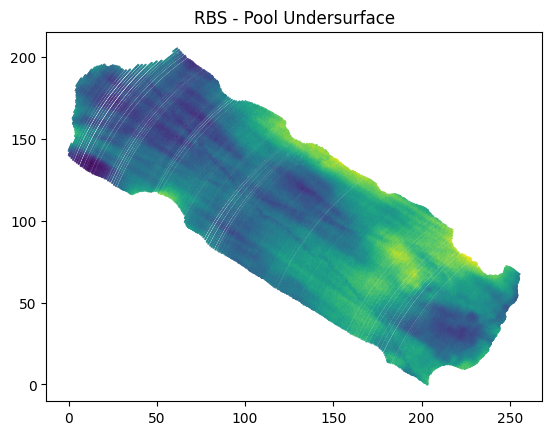

In [58]:

x_undersurface ,y_undersurface = pool_undersurface_coords[:, 0], pool_undersurface_coords[:, 1] 
z_undersurface = pool_undersurface_coords[:, 2]

outliers = get_outliers(z_undersurface)

x = x_undersurface[~outliers]
y = y_undersurface[~outliers]
z = z_surface_mean - z_undersurface[~outliers]

x = x * (metadata.get('x_max') - metadata.get('x_min'))
y = y * (metadata.get('y_max') - metadata.get('y_min'))
z = z * (metadata.get('z_max') - metadata.get('z_min')) 



plt.title('RBS - Pool Undersurface')
plt.scatter(x, y, c=z, cmap='viridis_r', s=0.2)
#plt.colorbar()
plt.savefig('img.png', dpi=300)
plt.show()
